## keras_merge_3_app_by_tuning
整体说明：
- 1、使用keras的Xception、ResNet50、InceptonResNetV2预训练模型分别提取特征向量
- 2、整合3个模型的特征向量
- 3、构建一个简单模型，进行训练、预测



In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from sklearn.utils import shuffle


train_data_dir = 'data/train2'
test_data_dir='data/test'


batch_size = 72   #19944/72=277  4986/72=69.25
epochs=200
VER=2
#模型权重文件
model_h5file_base="Merge-tuning-v{}.h5".format(VER)
model_h5file_base2="Merge-tuning-2-v{}.h5".format(VER)

#预测结果文件
pred_file_base="pred-Merge-tuning-v{}.csv".format(VER)
pred_file_base2="pred-Merge-tuning-2-v{}.csv".format(VER)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 得到不含输出层的权重文件
因为fine-tuning时，只保留了完整模型的权重文件

In [2]:

def rebuild_no_top_wieghts(MODEL, image_shape, weights_file, preprocess_input = None):
    input_tensor = Input((image_shape[0], image_shape[1], 3))
    x = input_tensor
    if preprocess_input:
        x = Lambda(preprocess_input)(x)
    
    base_model = MODEL(input_tensor=x, weights=None, include_top=False, pooling = 'avg')
    y = Dropout(0.5)(base_model.output) 
    y = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001))(y)  
    model = Model(inputs=base_model.input, outputs=y)
    
    model.load_weights(weights_file)  #用自己训练的权重文件
    
    #print(len(model.layers))
    no_top_model = Model(model.input, model.layers[-3].output) #去掉后面加的Dropout和Dense两层
    #print(len(no_top_model.layers))
    no_top_weights_file='no_top_'+weights_file
    no_top_model.save(no_top_weights_file)  #保存去掉后两层后的权重



In [3]:
rebuild_no_top_wieghts(ResNet50, (224, 224), "ResNet50-fine-tuning-3-v1.h5", preprocess_input = resnet50.preprocess_input)
print("rebuild ResNet50 OK")
rebuild_no_top_wieghts(Xception, (299, 299), "xception-fine-tuning-1.h5", preprocess_input = xception.preprocess_input)
print("rebuild Xception OK")
rebuild_no_top_wieghts(InceptionResNetV2, (299, 299), "InceptonResNetV2-fine-tuning-2-v2.h5", preprocess_input = inception_resnet_v2.preprocess_input)
print("rebuild InceptionResNetV2 OK")

rebuild ResNet50 OK
rebuild Xception OK
rebuild InceptionResNetV2 OK


In [8]:
#保存特征向量
def write_feature_data(MODEL, image_shape, weights_file, preprocess_input = None):
    input_tensor = Input((image_shape[0], image_shape[1], 3))
    x = input_tensor
    if preprocess_input:
        x = Lambda(preprocess_input)(x)
    
    base_model = MODEL(input_tensor=x, weights=weights_file, include_top=False, pooling = 'avg')

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(train_data_dir, image_shape, shuffle=False, 
                                              batch_size=90)
    test_generator = gen.flow_from_directory(test_data_dir, image_shape, shuffle=False, 
                                             batch_size=125, class_mode=None)
    print(train_generator.samples)
    print(test_generator.samples)
    
    train_feature = base_model.predict_generator(train_generator, train_generator.samples//90, verbose=1)
   
    test_feature = base_model.predict_generator(test_generator, test_generator.samples//125, verbose=1)
    
    with h5py.File("feature_tuning_%s.h5"%base_model.name) as h:
        h.create_dataset("train", data=train_feature)
        h.create_dataset("test", data=test_feature)
        h.create_dataset("label", data=train_generator.classes)
        


In [9]:
#用三个模型fine-tuning时，预测结果最好的权重文件提取特征向量
write_feature_data(ResNet50, (224, 224), "no_top_ResNet50-fine-tuning-3-v1.h5",  preprocess_input = resnet50.preprocess_input)
print("get ResNet50 freature over!")
write_feature_data(Xception, (299, 299), "no_top_xception-fine-tuning-1.h5",  preprocess_input = xception.preprocess_input)
print("get Xception freature over!")
write_feature_data(InceptionResNetV2, (299, 299), "no_top_InceptonResNetV2-fine-tuning-2-v2.h5",  preprocess_input = inception_resnet_v2.preprocess_input)
print("get InceptionResNetV2 freature over!")

Found 24930 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
24930
12500
100/100 [==============================] - 125s 1s/step
get ResNet50 freature over!
Found 24930 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
24930
12500
100/100 [==============================] - 304s 3s/step
get Xception freature over!
Found 24930 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
24930
12500
100/100 [==============================] - 355s 4s/step
get InceptionResNetV2 freature over!


In [10]:

#从文件中读取特征向量和标签

np.random.seed(2018)

X_train = []
X_test = []

for filename in ["feature_tuning_resnet50.h5", "feature_tuning_xception.h5", "feature_tuning_inception_resnet_v2.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)


In [11]:
#构造模型
input_tensor = Input(X_train.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [13]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如连续3个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/200
19944/19944 [==============================] - 11s 550us/step - loss: 0.0283 - acc: 0.9933 - val_loss: 0.0088 - val_acc: 0.9992

Epoch 00001: val_loss improved from inf to 0.00878, saving model to Merge-tuning-v2.h5
Epoch 2/200
19944/19944 [==============================] - 1s 56us/step - loss: 0.0064 - acc: 0.9984 - val_loss: 0.0081 - val_acc: 0.9994

Epoch 00002: val_loss improved from 0.00878 to 0.00810, saving model to Merge-tuning-v2.h5
Epoch 3/200
19944/19944 [==============================] - 1s 56us/step - loss: 0.0053 - acc: 0.9991 - val_loss: 0.0078 - val_acc: 0.9994

Epoch 00003: val_loss improved from 0.00810 to 0.00777, saving model to Merge-tuning-v2.h5
Epoch 4/200
19944/19944 [==============================] - 1s 56us/step - loss: 0.0048 - acc: 0.9990 - val_loss: 0.0076 - val_acc: 0.9994

Epoch 00004: val_loss improved from 0.00777 to 0.00757, saving model to Merge-tuning-v2.h5
Epoch 5/200
19944/19944 [========

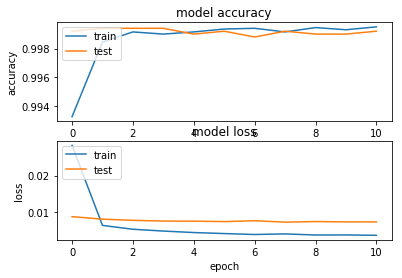

In [14]:
#可视化学习曲线
show_learning_curve(history)

In [18]:
#预测结果   
predict_on_model2(X_test,test_data_dir, 125, model, model_h5file_base, pred_file_base)


12500/12500 [==============================] - 1s 90us/step
Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


## 换个优化算法 

In [19]:
#构造模型

input_tensor = Input(X_train.shape[1:])

x = Dropout(0.5)(input_tensor)
x = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001))(x)
model2 = Model(input_tensor, x)

adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #训练快,把lr设置小一点
model2.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [20]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base2, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如连续3个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model2.fit(X_train, y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/200
19944/19944 [==============================] - 10s 525us/step - loss: 0.5852 - acc: 0.6945 - val_loss: 0.3764 - val_acc: 0.9545

Epoch 00001: val_loss improved from inf to 0.37642, saving model to Merge-tuning-2-v2.h5
Epoch 2/200
19944/19944 [==============================] - 1s 57us/step - loss: 0.3301 - acc: 0.9168 - val_loss: 0.2208 - val_acc: 0.9900

Epoch 00002: val_loss improved from 0.37642 to 0.22077, saving model to Merge-tuning-2-v2.h5
Epoch 3/200
19944/19944 [==============================] - 1s 56us/step - loss: 0.2129 - acc: 0.9679 - val_loss: 0.1447 - val_acc: 0.9950

Epoch 00003: val_loss improved from 0.22077 to 0.14474, saving model to Merge-tuning-2-v2.h5
Epoch 4/200
19944/19944 [==============================] - 1s 56us/step - loss: 0.1466 - acc: 0.9860 - val_loss: 0.1036 - val_acc: 0.9964

Epoch 00004: val_loss improved from 0.14474 to 0.10361, saving model to Merge-tuning-2-v2.h5
Epoch 5/200
19944/19944 [

19944/19944 [==============================] - 1s 55us/step - loss: 0.0090 - acc: 0.9987 - val_loss: 0.0098 - val_acc: 0.9992

Epoch 00036: val_loss improved from 0.00991 to 0.00976, saving model to Merge-tuning-2-v2.h5
Epoch 37/200
19944/19944 [==============================] - 1s 55us/step - loss: 0.0092 - acc: 0.9987 - val_loss: 0.0096 - val_acc: 0.9992

Epoch 00037: val_loss improved from 0.00976 to 0.00962, saving model to Merge-tuning-2-v2.h5
Epoch 38/200
19944/19944 [==============================] - 1s 55us/step - loss: 0.0087 - acc: 0.9984 - val_loss: 0.0095 - val_acc: 0.9992

Epoch 00038: val_loss improved from 0.00962 to 0.00950, saving model to Merge-tuning-2-v2.h5
Epoch 39/200
19944/19944 [==============================] - 1s 55us/step - loss: 0.0089 - acc: 0.9985 - val_loss: 0.0094 - val_acc: 0.9992

Epoch 00039: val_loss improved from 0.00950 to 0.00939, saving model to Merge-tuning-2-v2.h5
Epoch 40/200
19944/19944 [==============================] - 1s 55us/step - loss: 

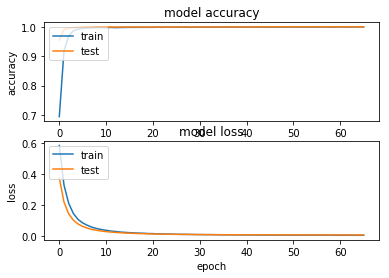

In [21]:
#可视化学习曲线
show_learning_curve(history)

In [23]:
#预测结果   
predict_on_model2(X_test,test_data_dir, 125, model2, model_h5file_base2, pred_file_base2)

12500/12500 [==============================] - 1s 91us/step
Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
